# Solar Wind-To-GIC in Austria (SW2GIC-AT) Machine Learning Model Training

This script first tests some basic model architectures to see which performs best at predicting the targets, then goes on to specifically train.

### Contents:

1. **Model testing**. Which model works best for this problem?<br>
    a. a basic neural network,<br>
    b. a gradient-boosting regressor,<br>
    c. or an LSTM with Attention?
2. **Training the best model** (an LSTM)<br>
    a. Training on Ex,<br>
    b. Training on Ey<br>
    c. Training on GIC_fit_SS1, and<br>
    d. Training on GIC_fit_SS5.<br>

### Input and Output

- See parameters.json for paths to files and plots.
- The samples for training, testing and for virtual real-time application are produced by 3_ExtractSamples and saved to "datapath". Separate files are saved for each possible target (6 in total): Ex_FUR, Ey_FUR, GIC1 and GIC5 measurements (GIC_), and GIC1 and GIC5 fits (GIC_fit_) from the modelled geoelectric field data.

**Author**: Rachel L. Bailey (ZAMG, r.bailey@zamg.ac.at), Feb 2021 - Sep 2021.

In [1]:
import os
from __future__ import unicode_literals, print_function, division
from datetime import datetime, timedelta
from io import open
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import re
from scipy.stats import pearsonr
import scipy.stats
import string
import time
import unicodedata

import pandas as pd
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from keras.losses import BinaryCrossentropy
import seaborn as sns

import keras
from keras.layers import Dense, LSTM, Layer, Dropout
from tensorflow.keras import backend as K
import tensorflow as tf

import sw2gic

with open('parameters.json', 'r') as fp:
    Params = json.load(fp)
    
sns.set_style(Params["sns_style"])

In [2]:
data_path = Params['datapath']
plot_path = Params['plotpath']
tr_set1, tr_set2, tr_set3 = [120, 20, 0], [120, 40, 10], [120, 60, 20]
ip_tr, op_tr, os_tr = tr_set2

# 1. Testing Basic Models

## Load data

Just start with the x-component for basic training.

In [3]:
# LOAD DATA
Ex_test = sw2gic.DataStorer('Ex_FUR', ip_tr, op_tr, os_tr)
Ex_test.load_training_data(data_path)
Ex_test.load_realtime_data(data_path, year='valid', enc=Ex_test.enc)

# CALCULATE METRICS FOR PERSISTENCE
m = Ex_test.calc_pers_metrics()

y_train_sc = Ex_test.scaler.inverse_transform(Ex_test.y_train)
y_test_sc =  Ex_test.scaler.inverse_transform(Ex_test.y_test)
y_rt_sc = Ex_test.scaler.inverse_transform(Ex_test.y_rt.reshape(-1,1))

rmse_pers_train = np.sqrt(mean_squared_error(Ex_test.pers_train, y_train_sc))
rmse_pers_test =  np.sqrt(mean_squared_error(Ex_test.pers_test, y_test_sc))
pcc_pers_train =  pearsonr(np.squeeze(Ex_test.pers_train), np.squeeze(y_train_sc))[0]
pcc_pers_test =   pearsonr(np.squeeze(Ex_test.pers_test), np.squeeze(y_test_sc))[0]

# Values for tensors:
seq_len = Ex_test.X_train.shape[1]
input_size = Ex_test.X_train.shape[2]
output_size = Ex_test.y_train.shape[1]
input_dim = seq_len*input_size

Loading years [2000, 2001]...


## 1a. Test a basic Linear Neural Network

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                9248      
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 9,385
Trainable params: 9,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
286/286 [==============================] - 1s 962us/step - loss: 0.0026
Epoch 2/12
286/286 [==============================] - 0s 966us/step - loss: 0.0021
Epoch 3/12
286/286 [==============================] - 0s 989us/step - loss: 0.0022
Epoch 4/12
286/286 [==============================] - 0s 985us/step - loss: 0.0020
Epoch 5/12
286/286 [=============================

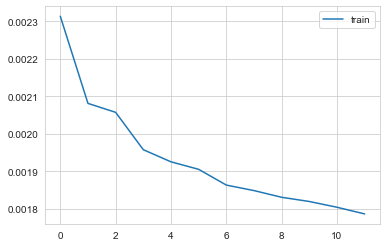

In [40]:
# Build the Keras model:
model_NN = keras.Sequential()
model_NN.add(Dense(32, input_dim=input_dim, activation='relu'))
model_NN.add(Dense(4, activation='relu'))
model_NN.add(Dense(1, activation='sigmoid'))

# Compile
model_NN.compile('adam', loss=sw2gic.min_max_loss)
model_NN.summary()

# Train
history = model_NN.fit(Ex_test.X_train.reshape((Ex_test.X_train.shape[0], input_dim)), Ex_test.y_train, epochs=12)

# Plot loss over time
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

(train)  RMSE = 16.83 (34.79) mV/km 	PCC = 0.81 (0.45)
(test)   RMSE = 24.32 (35.89) mV/km 	PCC = 0.68 (0.53)


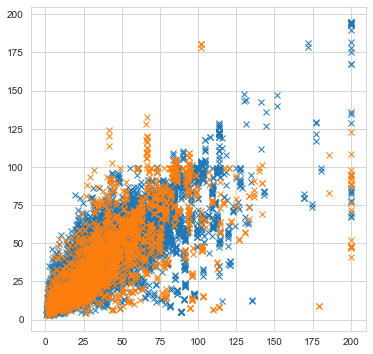


REAL-TIME APPLICATION
----------------------
POD = 0.64 (0.35)
POFD = 0.01 (0.00)
RMSE = 13.20 (9.46) mV/km
PCC = 0.56 (0.59)


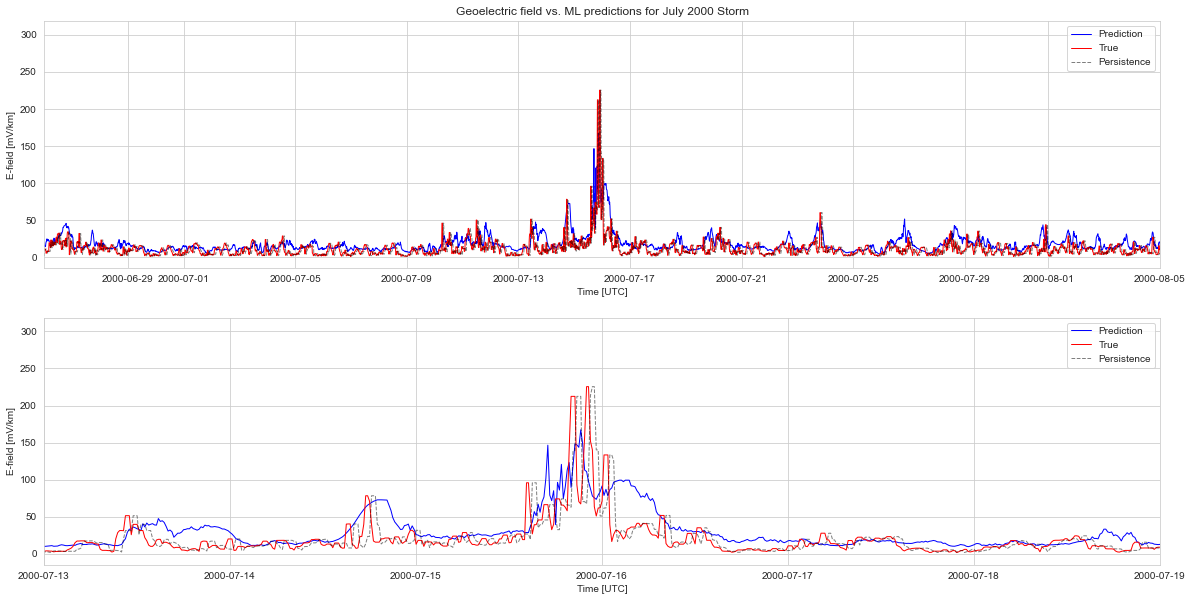

In [41]:
pred_train = model_NN.predict(Ex_test.X_train.reshape((Ex_test.X_train.shape[0], input_dim)))
pred_test =  model_NN.predict(Ex_test.X_test.reshape((Ex_test.X_test.shape[0], input_dim)))
pred_rt =    model_NN.predict(Ex_test.X_rt.reshape((Ex_test.X_rt.shape[0], input_dim)))

nn_pred_train = Ex_test.scaler.inverse_transform(pred_train.reshape(-1,1))
nn_pred_test =  Ex_test.scaler.inverse_transform(pred_test.reshape(-1,1))
nn_pred_rt =    Ex_test.scaler.inverse_transform(pred_rt.reshape(-1,1))

y_train_sc = Ex_test.scaler.inverse_transform(Ex_test.y_train)
y_test_sc =  Ex_test.scaler.inverse_transform(Ex_test.y_test)
rmse_train = np.sqrt(mean_squared_error(nn_pred_train, y_train_sc))
rmse_test =  np.sqrt(mean_squared_error(nn_pred_test, y_test_sc))
pcc_train = pearsonr(np.squeeze(nn_pred_train), np.squeeze(y_train_sc))[0]
pcc_test =  pearsonr(np.squeeze(nn_pred_test), np.squeeze(y_test_sc))[0]
                             
print("(train)  RMSE = {:.2f} ({:.2f}) mV/km \tPCC = {:.2f} ({:.2f})".format(rmse_train, rmse_pers_train, pcc_train, pcc_pers_train))
print("(test)   RMSE = {:.2f} ({:.2f}) mV/km \tPCC = {:.2f} ({:.2f})".format(rmse_test, rmse_pers_test, pcc_test, pcc_pers_test))

fig = plt.figure(figsize=(6,6))
plt.plot(y_train_sc, nn_pred_train, 'x')
plt.plot(y_test_sc, nn_pred_test, 'x')
plt.gca().set_aspect('equal', 'box')
plt.show()

print("\nREAL-TIME APPLICATION\n----------------------")

CM, CM_pers = sw2gic.compute_CM(y_rt_sc, nn_pred_rt, Ex_test.pers_rt, threshold=60)
sw2gic.compute_metrics(y_rt_sc, nn_pred_rt, Ex_test.pers_rt)
sw2gic.plot_on_time_series(y_rt_sc, nn_pred_rt, Ex_test.pers_rt, year=2000)

## 1b. Test a Gradient Boosting Regressor

In [34]:
import xgboost as xgb

model_XGB = xgb.XGBRegressor(objective='reg:squarederror', 
                             alpha=1, colsample_bytree=0.2,
                             max_depth=4,
                             n_estimators=400
                             )
model_XGB.fit(Ex_test.X_train.reshape((Ex_test.X_train.shape[0], input_dim)), 
              Ex_test.y_train.ravel())

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

(train)  RMSE = 6.27 (34.79) mV/km 	PCC = 0.98 (0.45)
(test)   RMSE = 23.50 (35.89) mV/km 	PCC = 0.70 (0.53)


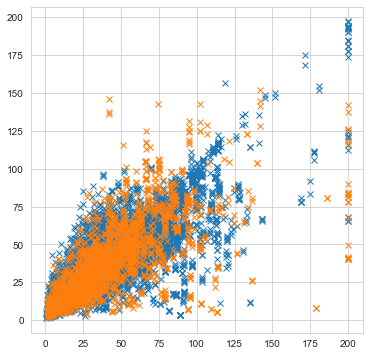


REAL-TIME APPLICATION
----------------------
POD = 0.66 (0.35)
POFD = 0.01 (0.00)
RMSE = 13.48 (9.46) mV/km
PCC = 0.57 (0.59)


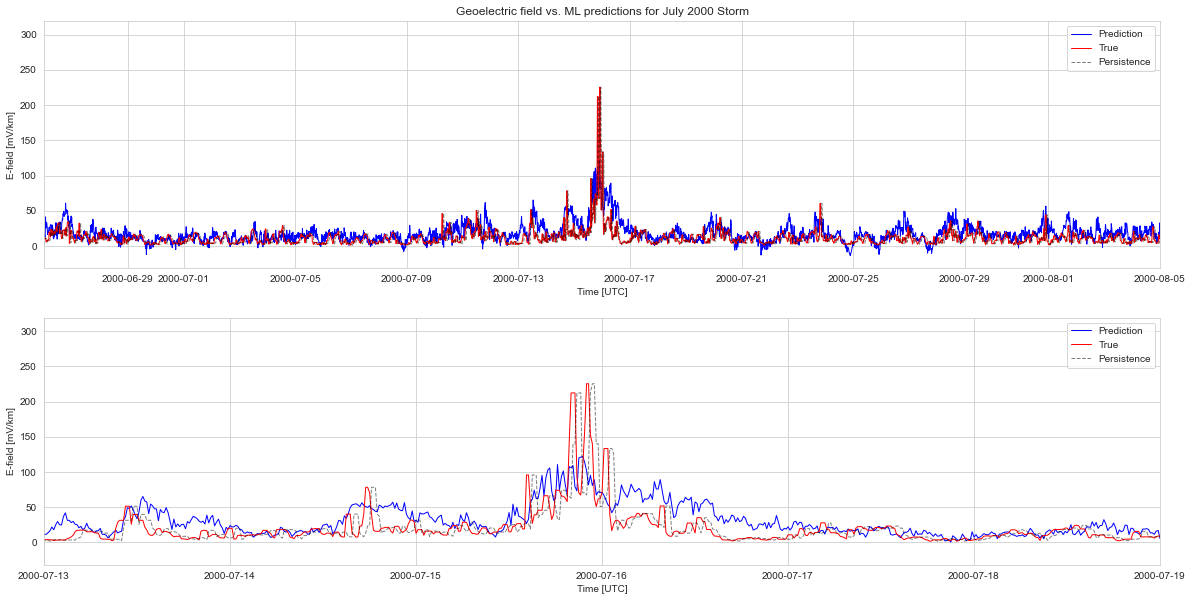

In [35]:
pred_train = model_XGB.predict(Ex_test.X_train.reshape((Ex_test.X_train.shape[0], input_dim)))
pred_test =  model_XGB.predict(Ex_test.X_test.reshape((Ex_test.X_test.shape[0], input_dim)))
pred_rt =    model_XGB.predict(Ex_test.X_rt.reshape((Ex_test.X_rt.shape[0], input_dim)))

xgb_pred_train = Ex_test.scaler.inverse_transform(pred_train.reshape(-1,1))
xgb_pred_test =  Ex_test.scaler.inverse_transform(pred_test.reshape(-1,1))
xgb_pred_rt =    Ex_test.scaler.inverse_transform(pred_rt.reshape(-1,1))

y_train_sc = Ex_test.scaler.inverse_transform(Ex_test.y_train)
y_test_sc =  Ex_test.scaler.inverse_transform(Ex_test.y_test)
rmse_train = np.sqrt(mean_squared_error(xgb_pred_train, y_train_sc))
rmse_test =  np.sqrt(mean_squared_error(xgb_pred_test, y_test_sc))
pcc_train = pearsonr(np.squeeze(xgb_pred_train), np.squeeze(y_train_sc))[0]
pcc_test =  pearsonr(np.squeeze(xgb_pred_test), np.squeeze(y_test_sc))[0]
                             
print("(train)  RMSE = {:.2f} ({:.2f}) mV/km \tPCC = {:.2f} ({:.2f})".format(rmse_train, rmse_pers_train, pcc_train, pcc_pers_train))
print("(test)   RMSE = {:.2f} ({:.2f}) mV/km \tPCC = {:.2f} ({:.2f})".format(rmse_test, rmse_pers_test, pcc_test, pcc_pers_test))

fig = plt.figure(figsize=(6,6))
plt.plot(y_train_sc, nn_pred_train, 'x')
plt.plot(y_test_sc, nn_pred_test, 'x')
plt.gca().set_aspect('equal', 'box')
plt.show()

print("\nREAL-TIME APPLICATION\n----------------------")

CM, CM_pers = sw2gic.compute_CM(y_rt_sc, xgb_pred_rt, Ex_test.pers_rt, threshold=60)
sw2gic.compute_metrics(y_rt_sc, xgb_pred_rt, Ex_test.pers_rt)
sw2gic.plot_on_time_series(y_rt_sc, xgb_pred_rt, Ex_test.pers_rt, year=2000)

## 1c. Test LSTM with Attention

Types of attention: https://towardsdatascience.com/attention-in-neural-networks-e66920838742

Attention function came from here: https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm

Custom loss functions: https://keras.io/api/losses/#creating-custom-losses

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 12, 32)            7296      
_________________________________________________________________
basic_attention_9 (BasicAtte (None, 12, 32)            44        
_________________________________________________________________
lstm_19 (LSTM)               (None, 4)                 592       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 5         
Total params: 7,937
Trainable params: 7,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
286/286 [==============================] - 6s 10ms/step - loss: 0.0054
Epoch 2/15
286/286 [==============================] - 3s 10ms/step - loss: 0.0022
Epoch 3/15
286/286 [==============================] - 3s 9ms/step - loss: 0.0022
Epoc

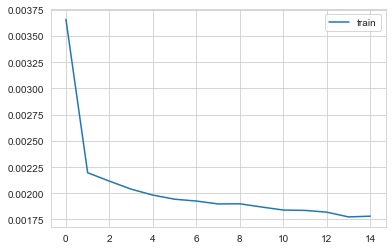

In [36]:
model_RNN = keras.Sequential()
model_RNN.add(LSTM(32, return_sequences=True, input_shape=(seq_len, input_size)))
model_RNN.add(sw2gic.BasicAttention(return_sequences=True))
model_RNN.add(LSTM(4))
model_RNN.add(Dense(1, activation='sigmoid'))
model_RNN.summary()

model_RNN.compile('adam', loss=sw2gic.min_max_loss)
history = model_RNN.fit(Ex_test.X_train, Ex_test.y_train, epochs=15, batch_size=32)
print("Done!")

plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

(train)  RMSE = 17.29 (34.79) mV/km 	PCC = 0.81 (0.45)
(test)   RMSE = 23.98 (35.89) mV/km 	PCC = 0.70 (0.53)


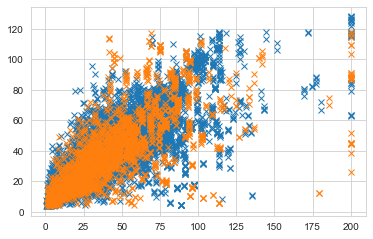


REAL-TIME APPLICATION
----------------------
POD = 0.56 (0.35)
POFD = 0.01 (0.00)
RMSE = 11.79 (9.46) mV/km
PCC = 0.59 (0.59)


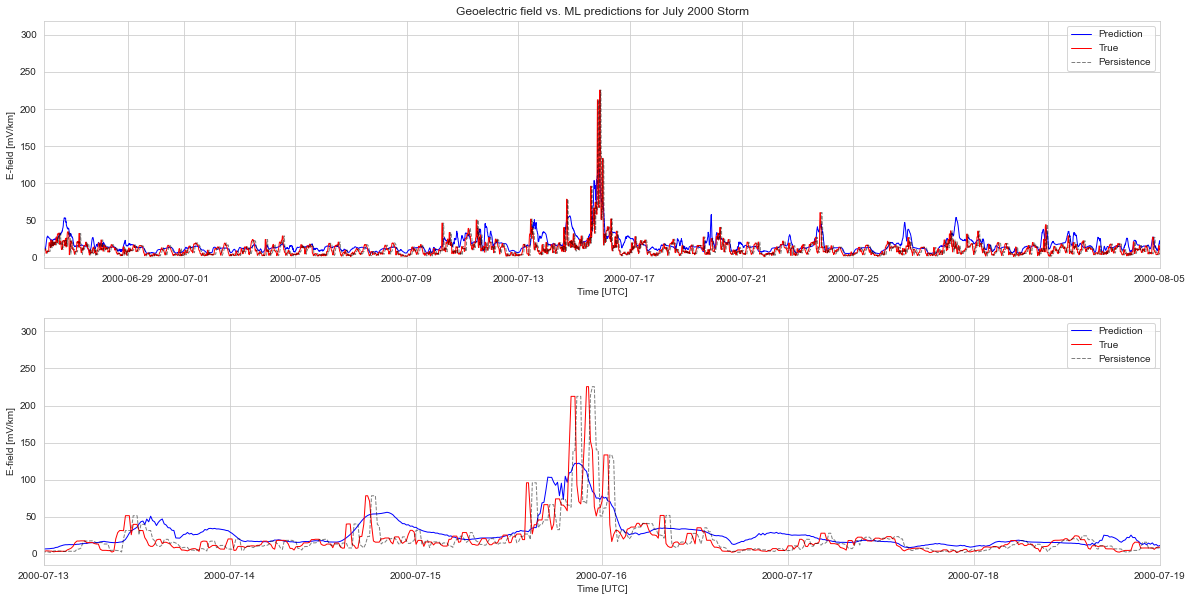

In [37]:
pred_train = model_RNN.predict(Ex_test.X_train)
pred_test =  model_RNN.predict(Ex_test.X_test)
pred_rt =    model_RNN.predict(Ex_test.X_rt)

rnn_pred_train = Ex_test.scaler.inverse_transform(pred_train.reshape(-1,1))
rnn_pred_test =  Ex_test.scaler.inverse_transform(pred_test.reshape(-1,1))
rnn_pred_rt =    Ex_test.scaler.inverse_transform(pred_rt.reshape(-1,1))

y_train_sc = Ex_test.scaler.inverse_transform(Ex_test.y_train)
y_test_sc =  Ex_test.scaler.inverse_transform(Ex_test.y_test)
rmse_train = np.sqrt(mean_squared_error(rnn_pred_train, y_train_sc))
rmse_test =  np.sqrt(mean_squared_error(rnn_pred_test, y_test_sc))
pcc_train = pearsonr(np.squeeze(rnn_pred_train), np.squeeze(y_train_sc))[0]
pcc_test =  pearsonr(np.squeeze(rnn_pred_test), np.squeeze(y_test_sc))[0]
                             
print("(train)  RMSE = {:.2f} ({:.2f}) mV/km \tPCC = {:.2f} ({:.2f})".format(rmse_train, rmse_pers_train, pcc_train, pcc_pers_train))
print("(test)   RMSE = {:.2f} ({:.2f}) mV/km \tPCC = {:.2f} ({:.2f})".format(rmse_test, rmse_pers_test, pcc_test, pcc_pers_test))

fig = plt.figure(figsize=(6,6))
plt.plot(y_train_sc, rnn_pred_train, 'x')
plt.plot(y_test_sc, rnn_pred_test, 'x')
plt.gca().set_aspect('equal', 'box')
plt.show()

print("\nREAL-TIME APPLICATION\n----------------------")

CM, CM_pers = sw2gic.compute_CM(y_rt_sc, rnn_pred_rt, Ex_test.pers_rt, threshold=60)
sw2gic.compute_metrics(y_rt_sc, rnn_pred_rt, Ex_test.pers_rt)
sw2gic.plot_on_time_series(y_rt_sc, rnn_pred_rt, Ex_test.pers_rt, year=2000)

## Conclusion: Which model to use?

Although the results of the train/test comparison come out similarly between the Neural Network, Gradient Boosting Regressor and the LSTM, the LSTM performs better in the real-time application, suggesting better model behaviour across the spectrum and on new data.

Onwards...

***

# 2. Model Training

### Building a more complex LSTM for all outputs

#### Things that have already been checked:
- The model seems to not train as well when using the mean over ten minutes as input from the solar wind. It does better when only subsampled values from every ten minutes.
- Using input time ranges longer than 120 minutes doesn't seem to lead to any improvement.
- Using data from L1 rather than data forward-propagated to the bow shock: It doesn't work as well due to the obvious problem of varying arrival timing, and since forward-propagating is not too tricky, it's not worth using L1 instead.
- A batch size of 32 is a pretty good approach.
- Minimising the ranges in the SWEncoder (see notebook #3) increases model learning ability (probably because, otherwise, the entirely of the values are in one encoding block for the mode part). It also seems to make training more stable. BUT if you go down too far (e.g. reducing the min./max. to half the values of the maximum outliers), the accuracy of the sign of E reduces from 0.80 to 0.75 - have to watch out for that.
- MSE vs. the max/min loss function. The MSE-trained model could not model the peaks and troughs well, while the min/max-trained model did better in almost all metrics.

### Define training parameters

In [3]:
loss_weights = [1500,1]
patience = 8
n_folds = 4

eval_metrics = ['rmse_rt', 'pcc_rt', 'acc_rt', 'TSS_rt', 'BS_rt']
weighting    = [ 1,         1,        0.5,      1,        0.5   ]
E_threshold = 60

#### Compile and train model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 12, 24)]     0                                            
__________________________________________________________________________________________________
lstm_all (LSTM)                 (None, 12, 64)       22784       input_layer[0][0]                
__________________________________________________________________________________________________
attn_reg (BasicAttention)       (None, 12, 64)       76          lstm_all[0][0]                   
__________________________________________________________________________________________________
attn_cla (BasicAttention)       (None, 12, 64)       76          lstm_all[0][0]                   
____________________________________________________________________________________________

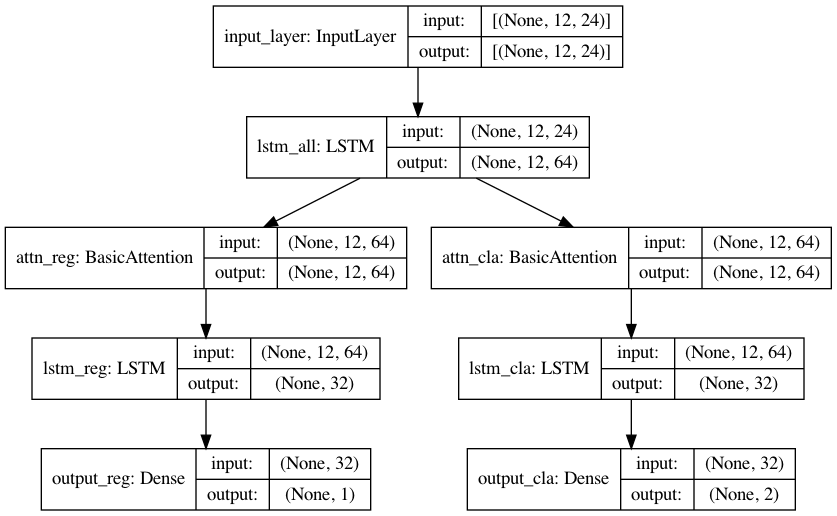

In [6]:
from keras.utils import plot_model

model = sw2gic.get_model(nhidden=64)
model.summary()
plot_model(model, to_file=os.path.join(plot_path, "lstm_architecture.png"), show_shapes=True)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 12, 24)]          0         
_________________________________________________________________
lstm_all (LSTM)              (None, 12, 64)            22784     
_________________________________________________________________
attn_reg (BasicAttention)    (None, 12, 64)            76        
_________________________________________________________________
lstm_reg (LSTM)              (None, 32)                12416     
_________________________________________________________________
output_reg (Dense)           (None, 1)                 33        
Total params: 35,309
Trainable params: 35,309
Non-trainable params: 0
_________________________________________________________________


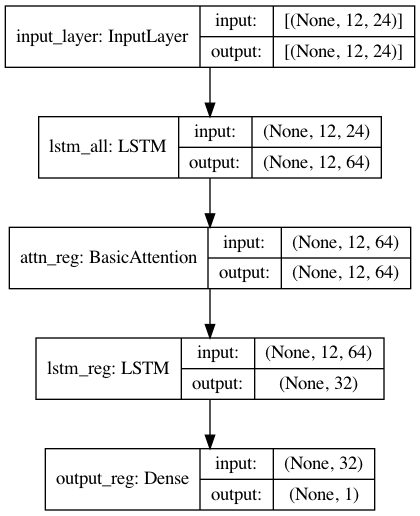

In [7]:
model = sw2gic.get_model(predict_sign=False, nhidden=64)
model.summary()
plot_model(model, to_file=os.path.join(plot_path, "lstm_architecture_nosign.png"), show_shapes=True)

In [6]:
def run_hyperparameter_tuning(v, all_options, i_split=None, E_threshold=60):

    save_metrics = ['rmse', 'pcc', 'acc', 'TSS', 'HSS', 'BS']
    cv_scores_hpt = {x: {'train': [], 'test': [], 'rt': []} for x in save_metrics}

    for n_iter, iter_options in enumerate(all_options):
        opt_batch_size, opt_patience, opt_loss_weights = iter_options[0], iter_options[1], iter_options[2]
        opt_epochs, opt_rb_weights, opt_dropout = iter_options[3], iter_options[4], iter_options[5]
        opt_nhidden = iter_options[6]
        print("Evaluating parameter set #{} of {}...".format(n_iter+1, n_options))

        pdict = {'p': opt_patience, 'ep': opt_epochs, 'bs': opt_batch_size, 'do': opt_dropout,
                 'lw': opt_loss_weights, 'rbw': opt_rb_weights, 'nh': opt_nhidden}

        avg_rmse = {x: {'train': [], 'test': [], 'rt': []} for x in save_metrics}
        for i_seed in [1, 42, 123]:
            print(" -- Using seed {}!".format(i_seed))
            print_params = (True if i_seed == 1 else False)
            model = sw2gic.fit_model(v, pdict, fit_verbose=0, print_params=print_params, 
                                     i_split=i_split, use_callback=False, plot_loss=False, seed=i_seed)
            v.make_predictions(model, threshold=E_threshold, show_plot=False)
            for m in save_metrics:
                for dstr in avg_rmse[m].keys():
                    avg_rmse[m][dstr].append(v.pred_metrics['{}_{}'.format(m, dstr)])
        print(avg_rmse['rmse'])
        for m in save_metrics:
            for dstr in avg_rmse[m].keys():
                cv_scores_hpt[m][dstr].append(np.mean(avg_rmse[m][dstr]))
                
    return cv_scores_hpt


def print_hpt_results(all_options, cv_scores, m_print):
    '''Prints the results from the hyperparameter tuning to choose a parameter set.
    all_options and cv_scores are as defined, m_print is the metric in
    save_metrics to print.'''
    
    print("Printing results for {}...".format(m_print))
    for i_opt, options in enumerate(all_options):
        print("{}) {:.3f} - {:.3f} - {:.3f} - {}".format(i_opt, cv_scores[m_print]['train'][i_opt],
                                                         cv_scores[m_print]['test'][i_opt],
                                                         cv_scores[m_print]['rt'][i_opt],
                                                         options))
    print("")

In [9]:
hpt_options = {'batch_size': [16, 32, 64], #[32], #
               'patience': [8], #[6,8], # only use this if restore_best_weights=True
               'loss_weights': [[1000,1], [2000,1]],
               'epochs': [10, 15, 20, 25],
               'restore_best_weights': [False],
               'p_dropout': [0.1, 0.3],
               'n_hidden': [32, 64, 128]}

basic_options = {'batch_size': [16],
               'patience': [8],
               'loss_weights': [[2000,1]],
               'epochs': [20],
               'restore_best_weights': [False],
               'p_dropout': [0.3],
               'n_hidden': [128]}

save_metrics = ['rmse', 'pcc', 'acc', 'TSS', 'HSS', 'BS']
all_options = list(itertools.product(*hpt_options.values()))
all_basic_options = list(itertools.product(*basic_options.values()))
n_options_all = len(all_options)
E_threshold, gic_threshold = 75, 5
# Numner of runs for random selection:
n_runs = 30
random.seed(n_runs)
all_options = random.sample(all_options, 30)
n_options = len(all_options)
print("Number of loops: {} (subset of {})".format(n_options, n_options_all))

Number of loops: 30 (subset of 144)


# Train on Ex and Ey

#### Read data

In [8]:
Ex_NAME, Ey_NAME = 'Ex_FUR', 'Ey_FUR'
Ex_noqt_NAME, Ey_noqt_NAME = Ex_NAME + '_noqt', Ey_NAME + '_noqt'
suffix_model = '' # '_mse' # 

# LOAD DATA
Ex_qt = sw2gic.DataStorer(Ex_NAME, ip_tr, op_tr, os_tr)
Ex_qt.load_training_data(data_path)
Ex_qt.load_realtime_data(data_path, year='valid', enc=Ex_qt.enc)

Ey_qt = sw2gic.DataStorer(Ey_NAME, ip_tr, op_tr, os_tr)
Ey_qt.load_training_data(data_path, enc=Ex_qt.enc)
Ey_qt.load_realtime_data(data_path, year='valid', enc=Ex_qt.enc)

# CALCULATE METRICS FOR PERSISTENCE
m = Ex_qt.calc_pers_metrics()
m = Ey_qt.calc_pers_metrics()

use_noqt = False
if use_noqt:
    Ex, Ey = Ex_noqt, Ey_noqt
else:
    Ex, Ey = Ex_qt, Ey_qt

filename_Ex_save = 'models/lstm_{}{}.h5'.format(Ex.varname, suffix_model)
filename_Ey_save = 'models/lstm_{}{}.h5'.format(Ey.varname, suffix_model)
filename_Ex_save_temp = 'models/temp_lstm_{}{}.h5'.format(Ex.varname, suffix_model)
filename_Ey_save_temp = 'models/temp_lstm_{}{}.h5'.format(Ey.varname, suffix_model)

Loading years [2000, 2001]...
Loading years [2000, 2001]...


## Train on Ex

#### Hyperparameter Tuning

In [14]:
v = Ex
print("Training on variable {} with parameters {}...\n".format(v.varname, v.suffix))
start_time_hpt = time.time()
cv_scores_hpt_Ex = run_hyperparameter_tuning(v, all_options, E_threshold=E_threshold)
end_time_hpt = time.time()
print("")
print("Model runs took {} minutes!".format((end_time_hpt-start_time_hpt)/60.))

Training on variable Ex_FUR with parameters _0120_0040_0010...

Evaluating parameter set #1 of 30...
 -- Using seed 1!
    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=64
	restore_best_weights=False
	seed=1
	epochs=25
	use_callback=False
	p_dropout=0.1
	n_hidden=32
 -- Using seed 42!
 -- Using seed 123!
{'train': [15.910605162867249, 16.12420914847233, 16.494356612687014], 'test': [23.930083799848546, 24.468423971296104, 25.063308939671373], 'rt': [11.499098118083442, 12.216257940059602, 11.333381831827722]}
Evaluating parameter set #2 of 30...
 -- Using seed 1!
    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=32
	restore_best_weights=False
	seed=1
	epochs=10
	use_callback=False
	p_dropout=0.1
	n_hidden=128
 -- Using seed 42!
 -- Using seed 123!
{'train': [17.068234130798462, 16.983825659851004, 17.36895509272918], 'test': [24.042572031432435, 24.14693053761384, 24.569810748332127], 'rt': [11.877611541448243,

In [15]:
print_hpt_results(all_options, cv_scores_hpt_Ex, 'rmse')
print_hpt_results(all_options, cv_scores_hpt_Ex, 'pcc')
print_hpt_results(all_options, cv_scores_hpt_Ex, 'acc')
print_hpt_results(all_options, cv_scores_hpt_Ex, 'TSS')
print_hpt_results(all_options, cv_scores_hpt_Ex, 'HSS')

Printing results for rmse...
0) 16.176 - 24.487 - 11.683 - (64, 8, [2000, 1], 25, False, 0.1, 32)
1) 17.140 - 24.253 - 12.506 - (32, 8, [2000, 1], 10, False, 0.1, 128)
2) 15.723 - 23.975 - 12.056 - (16, 8, [1000, 1], 15, False, 0.1, 64)
3) 17.266 - 24.349 - 12.543 - (32, 8, [1000, 1], 10, False, 0.3, 128)
4) 15.369 - 24.527 - 11.598 - (32, 8, [1000, 1], 20, False, 0.3, 128)
5) 15.813 - 24.199 - 11.454 - (16, 8, [1000, 1], 20, False, 0.1, 32)
6) 17.515 - 24.105 - 12.706 - (64, 8, [1000, 1], 10, False, 0.3, 128)
7) 17.403 - 23.894 - 12.566 - (64, 8, [1000, 1], 10, False, 0.1, 32)
8) 16.267 - 23.857 - 12.202 - (16, 8, [2000, 1], 15, False, 0.3, 64)
9) 13.113 - 24.871 - 12.129 - (16, 8, [1000, 1], 25, False, 0.1, 128)
10) 15.934 - 24.454 - 10.991 - (64, 8, [1000, 1], 25, False, 0.3, 64)
11) 16.873 - 24.140 - 12.028 - (16, 8, [1000, 1], 10, False, 0.1, 64)
12) 15.098 - 24.468 - 12.029 - (32, 8, [1000, 1], 20, False, 0.1, 128)
13) 16.351 - 24.161 - 12.437 - (16, 8, [1000, 1], 15, False, 0.1,

    Training with following parameters:
	patience=8
	loss_weights=[1000, 1]
	batch_size=64
	restore_best_weights=False
	seed=1
	epochs=10
	use_callback=False
	p_dropout=0.1
	n_hidden=32
POD = 0.47 (0.07)
POFD = 0.04 (0.01)
POD = 0.51 (0.19)
POFD = 0.05 (0.01)
POD = 0.52 (0.30)
POFD = 0.00 (0.00)

TRAIN / TEST DATASETS
----------------------
(train)	RMSE = 17.38 (34.79) mV/km 	PCC = 0.80 (0.45) 	ACC = 0.87 (0.70) 
(test)	RMSE = 23.88 (35.89) mV/km 	PCC = 0.69 (0.53) 	ACC = 0.85 (0.73) 


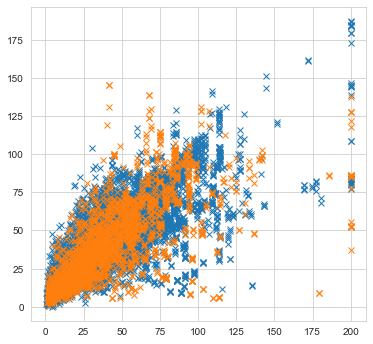


REAL-TIME APPLICATION
----------------------
(rt)	RMSE = 12.94 (9.46) mV/km 	PCC = 0.58 (0.59) 	ACC = 0.75 (0.69) 	TSS = 0.51 (0.30) 	BS = 1.84 (1.03) 


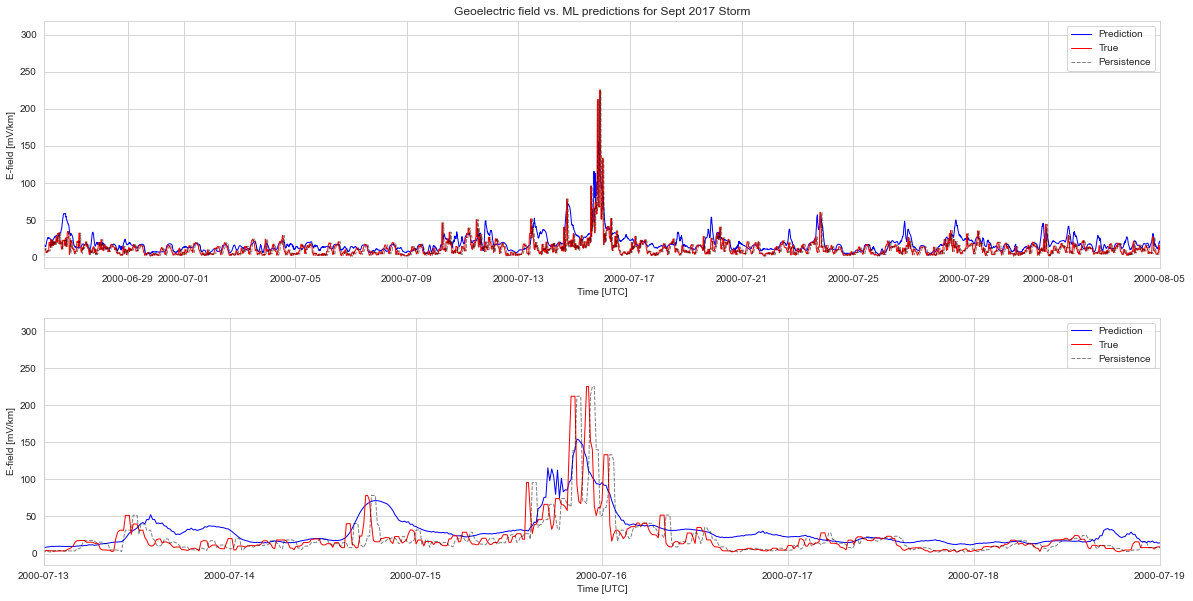

In [51]:
# CURRENT BEST MODEL
v = Ex
iter_options = all_options[7]
n_seed = 1

opt_batch_size, opt_patience, opt_loss_weights = iter_options[0], iter_options[1], iter_options[2]
opt_epochs, opt_rb_weights, opt_dropout = iter_options[3], iter_options[4], iter_options[5]
opt_nhidden = iter_options[6]

pdict = {'p': opt_patience, 'ep': opt_epochs, 'bs': opt_batch_size, 'do': opt_dropout,
         'lw': opt_loss_weights, 'rbw': opt_rb_weights, 'nh': opt_nhidden}

model_Ex = sw2gic.fit_model(v, pdict, fit_verbose=0, use_callback=False, plot_loss=False, seed=n_seed)
v.make_predictions(model_Ex, threshold=E_threshold, verbose=True)

-10 0.4443493505071866
-9 0.45808935328530676
-8 0.4716890237547943
-7 0.4863552975725435
-6 0.5007998357723153
-5 0.5153261191231084
-4 0.5305414925478336
-3 0.5460264750508994
-2 0.561470935242204
-1 0.5752104018512023
0 0.584941037186492
1 0.5891270408830526
2 0.5860691352159338
3 0.577436711530303
4 0.5647164858637094
5 0.5500626157331182
6 0.5350903331691583
7 0.5208928960101962
8 0.5074670375803823
9 0.4957431365324362


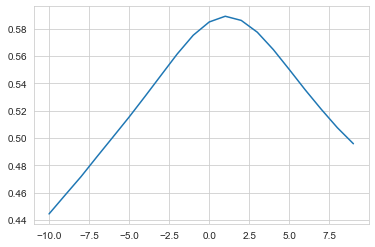

In [10]:
xcorr = []
for i in range(10, 0, -1):
    xcorr_ = pearsonr(np.squeeze(Ex.y_rt_sc[i:]), np.squeeze(Ex.pred_rt[:-i]))[0]
    print(-i, xcorr_)
    xcorr.append(xcorr_)
xcorr_ = pearsonr(np.squeeze(Ex.pred_rt), np.squeeze(Ex.y_rt_sc))[0]
xcorr.append(xcorr_)
print(0, xcorr_)
for i in range(1, 10):
    xcorr_ = pearsonr(np.squeeze(Ex.pred_rt[i:]), np.squeeze(Ex.y_rt_sc[:-i]))[0]
    print(i, xcorr_)
    xcorr.append(xcorr_)
    
plt.plot(np.arange(-10,10), xcorr)
plt.title("Plot of x-corr in time-step")
plt.show()

In [16]:
# Save final model to file
model_Ex.save(filename_Ex_save_temp)
# Save parameters to file:
pdict_Ex_save_temp = filename_Ex_save_temp.replace('lstm', 'pdict').replace('.h5', '.p')
with open(pdict_Ex_save_temp, 'wb') as handle:
    pickle.dump(pdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Model last saved on {}.".format(datetime.utcnow()))

Model last saved on 2021-09-02 07:18:27.794129.


#### Compare to last saved model

POD = 0.34 (0.07)
POFD = 0.01 (0.01)
POD = 0.38 (0.19)
POFD = 0.04 (0.01)
POD = 0.48 (0.30)
POFD = 0.00 (0.00)

TRAIN / TEST DATASETS
----------------------
(train)	RMSE = 17.45 (34.79) mV/km 	PCC = 0.80 (0.45) 	ACC = 0.87 (0.70) 
(test)	RMSE = 23.61 (35.89) mV/km 	PCC = 0.71 (0.53) 	ACC = 0.87 (0.73) 


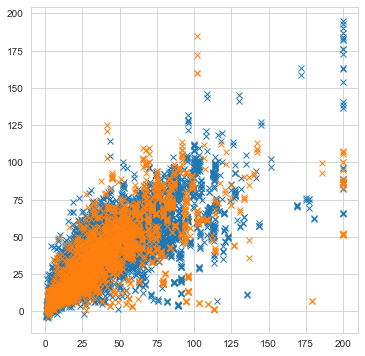


REAL-TIME APPLICATION
----------------------
(rt)	RMSE = 11.56 (9.46) mV/km 	PCC = 0.61 (0.59) 	ACC = 0.76 (0.69) 	TSS = 0.48 (0.30) 	BS = 1.34 (1.03) 


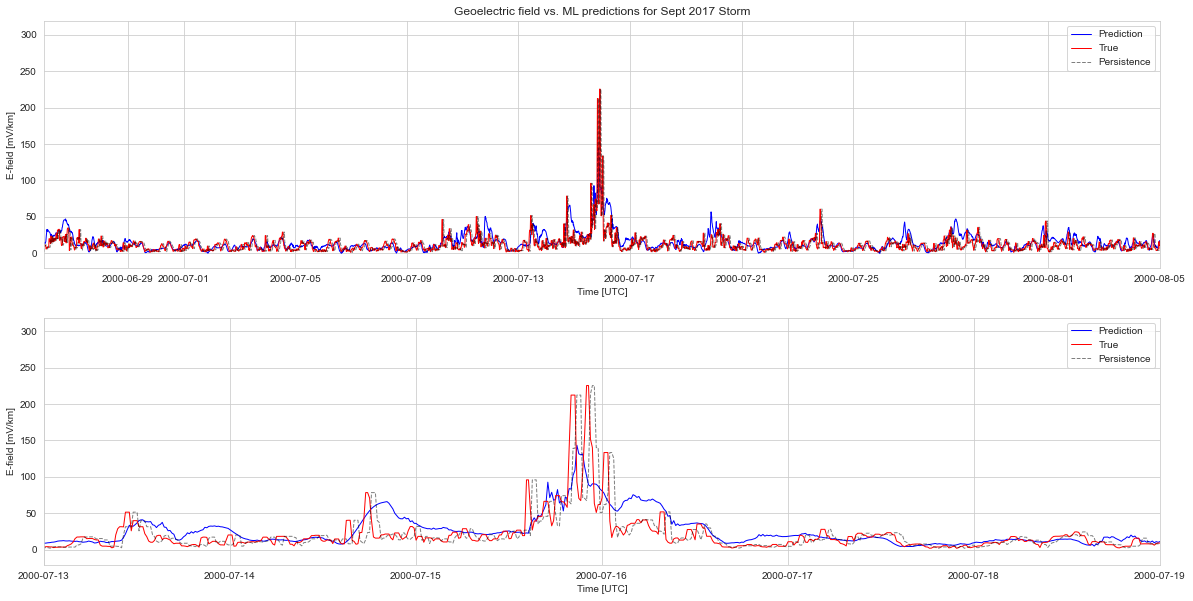

In [17]:
# Load best (ever) model
model_Ex = keras.models.load_model(filename_Ex_save, custom_objects={'BasicAttention': sw2gic.BasicAttention, 'min_max_loss': sw2gic.min_max_loss})
model_Ex.compile(optimizer="adam",loss=[sw2gic.min_max_loss, keras.losses.BinaryCrossentropy()],loss_weights=[1000,1])
with open(filename_Ex_save.replace('lstm', 'pdict').replace('.h5', '.p'), 'rb') as handle:
    pdict = pickle.load(handle)
print(pdict)
v.make_predictions(model_Ex, threshold=E_threshold, verbose=True)

In [52]:
# Save final model to file
model_Ex.save(filename_Ex_save)
# Save parameters to file:
pdict_Ex_save = filename_Ex_save.replace('lstm', 'pdict').replace('.h5', '.p')
with open(pdict_Ex_save, 'wb') as handle:
    pickle.dump(pdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Model last saved on {}.".format(datetime.utcnow()))

Model last saved on 2021-09-02 08:27:53.394312.


## Train on Ey

### Hyperparameter Tuning

In [16]:
v = Ey
print("Training on variable {} with parameters {}...\n".format(v.varname, v.suffix))
start_time_hpt = time.time()
cv_scores_hpt_Ey = run_hyperparameter_tuning(v, all_options, E_threshold=E_threshold)
end_time_hpt = time.time()
print("")
print("Model runs took {} minutes!".format((end_time_hpt-start_time_hpt)/60.))

Training on variable Ey_FUR with parameters _0120_0040_0010...

Evaluating parameter set #1 of 30...
 -- Using seed 1!
    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=64
	restore_best_weights=False
	seed=1
	epochs=25
	use_callback=False
	p_dropout=0.1
	n_hidden=32
 -- Using seed 42!
 -- Using seed 123!
{'train': [19.496398552495172, 19.497262693627913, 19.95173568110788], 'test': [33.601795624097335, 33.669515787115685, 33.90779986853282], 'rt': [14.168917717432093, 13.263160029067958, 13.29451366459212]}
Evaluating parameter set #2 of 30...
 -- Using seed 1!
    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=32
	restore_best_weights=False
	seed=1
	epochs=10
	use_callback=False
	p_dropout=0.1
	n_hidden=128
 -- Using seed 42!
 -- Using seed 123!
{'train': [20.684184607893503, 20.471923470538815, 20.600380268949657], 'test': [32.5720441455668, 32.33267230558593, 32.36700836701055], 'rt': [14.0245464334229, 13.48

In [17]:
print_hpt_results(all_options, cv_scores_hpt_Ey, 'rmse')
print_hpt_results(all_options, cv_scores_hpt_Ey, 'pcc')
print_hpt_results(all_options, cv_scores_hpt_Ey, 'acc')
print_hpt_results(all_options, cv_scores_hpt_Ey, 'TSS')
print_hpt_results(all_options, cv_scores_hpt_Ey, 'HSS')

Printing results for rmse...
0) 19.648 - 33.726 - 13.576 - (64, 8, [2000, 1], 25, False, 0.1, 32)
1) 20.585 - 32.424 - 13.841 - (32, 8, [2000, 1], 10, False, 0.1, 128)
2) 18.667 - 33.120 - 15.486 - (16, 8, [1000, 1], 15, False, 0.1, 64)
3) 20.449 - 32.387 - 14.424 - (32, 8, [1000, 1], 10, False, 0.3, 128)
4) 17.999 - 33.202 - 15.758 - (32, 8, [1000, 1], 20, False, 0.3, 128)
5) 18.543 - 32.919 - 14.708 - (16, 8, [1000, 1], 20, False, 0.1, 32)
6) 20.652 - 32.522 - 14.620 - (64, 8, [1000, 1], 10, False, 0.3, 128)
7) 21.282 - 32.728 - 13.684 - (64, 8, [1000, 1], 10, False, 0.1, 32)
8) 19.067 - 32.745 - 14.166 - (16, 8, [2000, 1], 15, False, 0.3, 64)
9) 15.372 - 33.815 - 15.855 - (16, 8, [1000, 1], 25, False, 0.1, 128)
10) 18.423 - 33.262 - 14.916 - (64, 8, [1000, 1], 25, False, 0.3, 64)
11) 19.873 - 33.500 - 14.440 - (16, 8, [1000, 1], 10, False, 0.1, 64)
12) 17.509 - 33.151 - 15.977 - (32, 8, [1000, 1], 20, False, 0.1, 128)
13) 19.359 - 32.656 - 15.314 - (16, 8, [1000, 1], 15, False, 0.1,

    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=32
	restore_best_weights=False
	seed=1
	epochs=10
	use_callback=False
	p_dropout=0.1
	n_hidden=32
POD = 0.49 (0.13)
POFD = 0.01 (0.01)
POD = 0.33 (0.22)
POFD = 0.06 (0.02)
POD = 0.39 (0.34)
POFD = 0.00 (0.00)

TRAIN / TEST DATASETS
----------------------
(train)	RMSE = 20.85 (31.66) mV/km 	PCC = 0.69 (0.53) 	ACC = 0.82 (0.59) 
(test)	RMSE = 32.80 (38.30) mV/km 	PCC = 0.58 (0.61) 	ACC = 0.79 (0.61) 


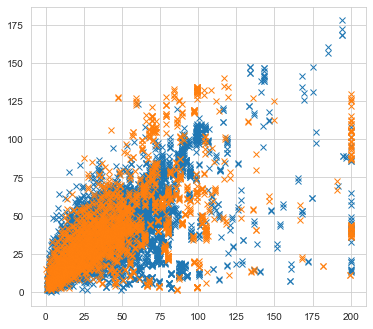


REAL-TIME APPLICATION
----------------------
(rt)	RMSE = 13.13 (10.72) mV/km 	PCC = 0.60 (0.59) 	ACC = 0.69 (0.66) 	TSS = 0.39 (0.33) 	BS = 1.11 (0.98) 


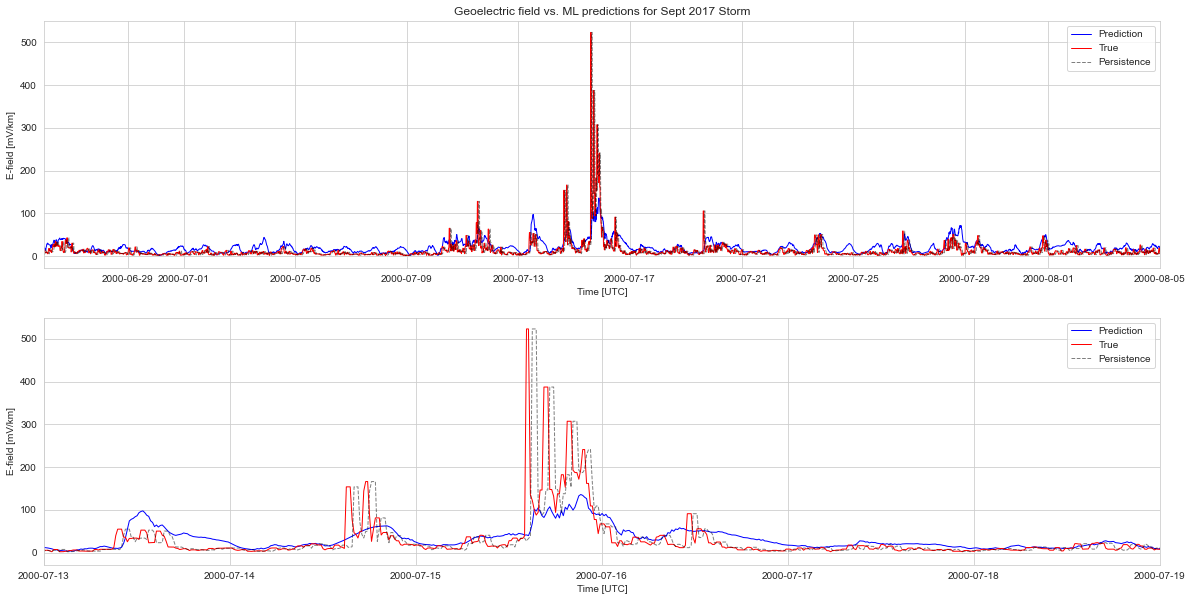

In [53]:
# CURRENT BEST MODEL
v = Ey
iter_options = all_options[28]
n_seed = 1#

opt_batch_size, opt_patience, opt_loss_weights = iter_options[0], iter_options[1], iter_options[2]
opt_epochs, opt_rb_weights, opt_dropout = iter_options[3], iter_options[4], iter_options[5]
opt_nhidden = iter_options[6]
pdict = {'p': opt_patience, 'ep': opt_epochs, 'bs': opt_batch_size, 'do': opt_dropout,
         'lw': opt_loss_weights, 'rbw': opt_rb_weights, 'nh': opt_nhidden}

model_Ey = sw2gic.fit_model(v, pdict, fit_verbose=0, use_callback=False, plot_loss=False, seed=n_seed)
v.make_predictions(model_Ey, threshold=E_threshold, verbose=True)

In [23]:
# Save final model to file
model_Ey.save(filename_Ey_save_temp)
# Save parameters to file:
pdict_Ey_save_temp = filename_Ey_save_temp.replace('lstm', 'pdict').replace('.h5', '.p')
with open(pdict_Ey_save_temp, 'wb') as handle:
    pickle.dump(pdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Model last saved on {}.".format(datetime.utcnow()))

Model last saved on 2021-09-02 07:28:04.377467.


#### Compare to last saved model

{'p': 8, 'ep': 20, 'bs': 64, 'do': 0.3, 'lw': [1000, 1], 'rbw': False, 'nh': 64}
POD = 0.49 (0.13)
POFD = 0.01 (0.01)
POD = 0.25 (0.22)
POFD = 0.04 (0.02)
POD = 0.33 (0.34)
POFD = 0.00 (0.00)

TRAIN / TEST DATASETS
----------------------
(train)	RMSE = 20.42 (31.66) mV/km 	PCC = 0.72 (0.53) 	ACC = 0.86 (0.59) 
(test)	RMSE = 34.62 (38.30) mV/km 	PCC = 0.54 (0.61) 	ACC = 0.81 (0.61) 


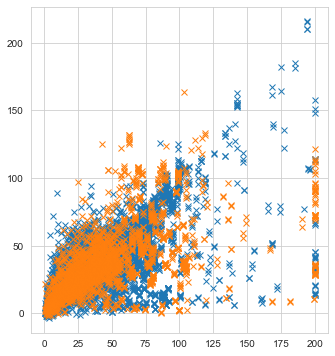


REAL-TIME APPLICATION
----------------------
(rt)	RMSE = 12.30 (10.72) mV/km 	PCC = 0.57 (0.59) 	ACC = 0.74 (0.66) 	TSS = 0.33 (0.33) 	BS = 0.89 (0.98) 


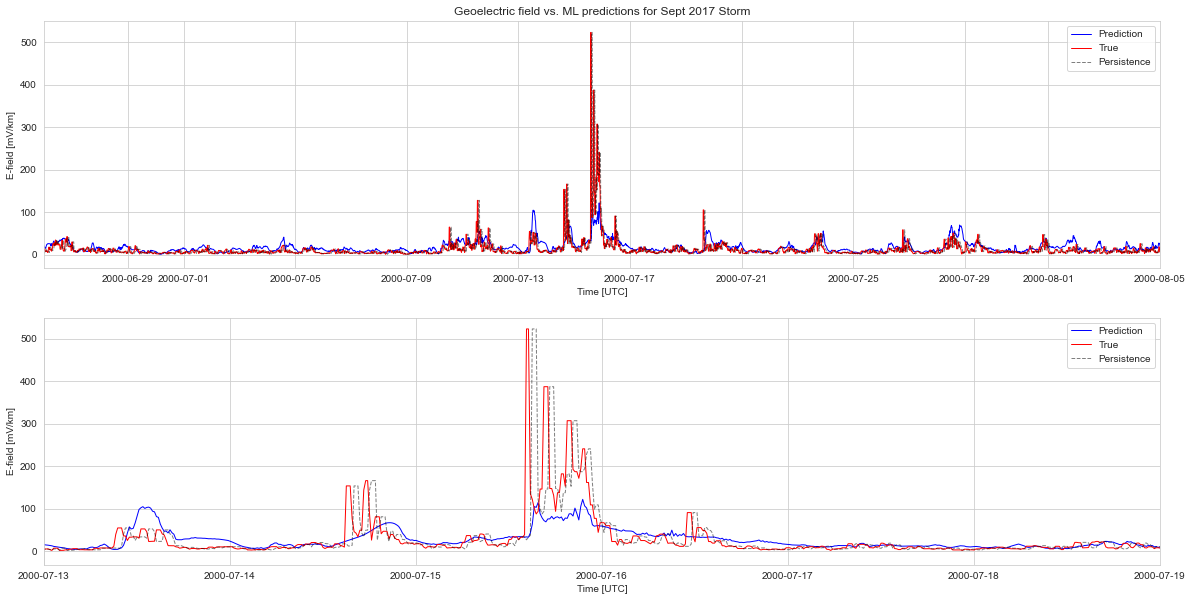

In [25]:
# Load best (ever) model
v = Ey
custom_objects = {'BasicAttention': sw2gic.BasicAttention, 'min_max_loss': sw2gic.min_max_loss}
model_Ey = keras.models.load_model(filename_Ey_save, custom_objects=custom_objects)
model_Ey.compile(optimizer="adam",loss=[sw2gic.min_max_loss, keras.losses.BinaryCrossentropy()],loss_weights=[1000,1])
with open(filename_Ey_save.replace('lstm', 'pdict').replace('.h5', '.p'), 'rb') as handle:
    pdict = pickle.load(handle)
print(pdict)
v.make_predictions(model_Ey, threshold=E_threshold, verbose=True)

In [54]:
# Save final model to file
model_Ey.save(filename_Ey_save)
# Save parameters to file:
pdict_Ey_save = filename_Ey_save.replace('lstm', 'pdict').replace('.h5', '.p')
with open(pdict_Ey_save, 'wb') as handle:
    pickle.dump(pdict, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model last saved on {}.".format(datetime.utcnow()))

Model last saved on 2021-09-02 08:30:08.353704.


# Train on GICs

#### Read data

In [11]:
GIC1_NAME, GIC5_NAME = 'GIC_fit_SS1', 'GIC_fit_SS5'
suffix_model = '' # '_mse' # 

# LOAD DATA
GIC1 = sw2gic.DataStorer(GIC1_NAME, ip_tr, op_tr, os_tr, predict_sign=False)
GIC1.load_training_data(data_path)
GIC1.load_realtime_data(data_path, year='valid', enc=GIC1.enc)

GIC5 = sw2gic.DataStorer(GIC5_NAME, ip_tr, op_tr, os_tr, predict_sign=False)
GIC5.load_training_data(data_path, enc=GIC1.enc)
GIC5.load_realtime_data(data_path, year='valid', enc=GIC1.enc)

# CALCULATE METRICS FOR PERSISTENCE
m = GIC1.calc_pers_metrics()
m = GIC5.calc_pers_metrics()

filename_GIC1_save = 'models/lstm_{}{}.h5'.format(GIC1.varname, suffix_model)
filename_GIC5_save = 'models/lstm_{}{}.h5'.format(GIC5.varname, suffix_model)
filename_GIC1_save_temp = 'models/temp_lstm_{}{}.h5'.format(GIC1.varname, suffix_model)
filename_GIC5_save_temp = 'models/temp_lstm_{}{}.h5'.format(GIC5.varname, suffix_model)

Loading years [2000, 2001]...
Loading years [2000, 2001]...


## Train on SS1

#### Run hyperparameter tuning

In [19]:
v = GIC1
print("Training on variable {} with parameters {}...\n".format(v.varname, v.suffix))
start_time_hpt = time.time()
cv_scores_hpt_GIC1 = run_hyperparameter_tuning(v, all_options, E_threshold=gic_threshold)
end_time_hpt = time.time()
print("")
print("Model runs took {} minutes!".format((end_time_hpt-start_time_hpt)/60.))

Training on variable GIC_fit_SS1 with parameters _0120_0040_0010...

Evaluating parameter set #1 of 30...
 -- Using seed 1!
    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=64
	restore_best_weights=False
	seed=1
	epochs=25
	use_callback=False
	p_dropout=0.1
	n_hidden=32
 -- Using seed 42!
 -- Using seed 123!
{'train': [1.0973925719819089, 1.082548542345443, 1.0790378539968877], 'test': [1.8026049947129987, 1.7807534269843108, 1.7783837777690852], 'rt': [0.7465212718212307, 0.7544004999036601, 0.802727313386088]}
Evaluating parameter set #2 of 30...
 -- Using seed 1!
    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=32
	restore_best_weights=False
	seed=1
	epochs=10
	use_callback=False
	p_dropout=0.1
	n_hidden=128
 -- Using seed 42!
 -- Using seed 123!
{'train': [1.1641618566492014, 1.131499056503467, 1.154178457020785], 'test': [1.8089662141488123, 1.7740768420905992, 1.7772489206332085], 'rt': [0.6899322472625

In [20]:
print_hpt_results(all_options, cv_scores_hpt_GIC1, 'rmse')
print_hpt_results(all_options, cv_scores_hpt_GIC1, 'pcc')
print_hpt_results(all_options, cv_scores_hpt_GIC1, 'acc')
print_hpt_results(all_options, cv_scores_hpt_GIC1, 'TSS')
print_hpt_results(all_options, cv_scores_hpt_GIC1, 'HSS')

Printing results for rmse...
0) 1.086 - 1.787 - 0.768 - (64, 8, [2000, 1], 25, False, 0.1, 32)
1) 1.150 - 1.787 - 0.726 - (32, 8, [2000, 1], 10, False, 0.1, 128)
2) 1.050 - 1.786 - 0.800 - (16, 8, [1000, 1], 15, False, 0.1, 64)
3) 1.157 - 1.789 - 0.736 - (32, 8, [1000, 1], 10, False, 0.3, 128)
4) 1.061 - 1.857 - 0.730 - (32, 8, [1000, 1], 20, False, 0.3, 128)
5) 1.037 - 1.846 - 0.732 - (16, 8, [1000, 1], 20, False, 0.1, 32)
6) 1.218 - 1.799 - 0.709 - (64, 8, [1000, 1], 10, False, 0.3, 128)
7) 1.200 - 1.762 - 0.724 - (64, 8, [1000, 1], 10, False, 0.1, 32)
8) 1.057 - 1.769 - 0.798 - (16, 8, [2000, 1], 15, False, 0.3, 64)
9) 0.927 - 1.839 - 0.919 - (16, 8, [1000, 1], 25, False, 0.1, 128)
10) 1.089 - 1.783 - 0.776 - (64, 8, [1000, 1], 25, False, 0.3, 64)
11) 1.121 - 1.809 - 0.736 - (16, 8, [1000, 1], 10, False, 0.1, 64)
12) 1.022 - 1.832 - 0.793 - (32, 8, [1000, 1], 20, False, 0.1, 128)
13) 1.067 - 1.799 - 0.797 - (16, 8, [1000, 1], 15, False, 0.1, 32)
14) 0.990 - 1.842 - 0.762 - (16, 8, [

    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=32
	restore_best_weights=False
	seed=123
	epochs=10
	use_callback=False
	p_dropout=0.1
	n_hidden=32

TRAIN / TEST DATASETS
----------------------
(train)	RMSE = 1.13 (1.92) mV/km 	PCC = 0.75 (0.52) 	ACC = 0.00 (0.00) 
(test)	RMSE = 1.71 (2.36) mV/km 	PCC = 0.63 (0.53) 	ACC = 0.00 (0.00) 


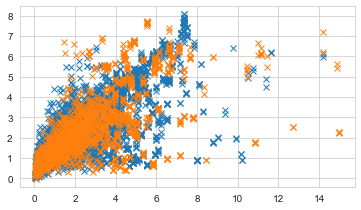


REAL-TIME APPLICATION
----------------------
(rt)	RMSE = 0.82 (0.51) mV/km 	PCC = 0.59 (0.61) 	ACC = 0.00 (0.00) 	TSS = 0.49 (0.29) 	BS = 1.55 (0.98) 


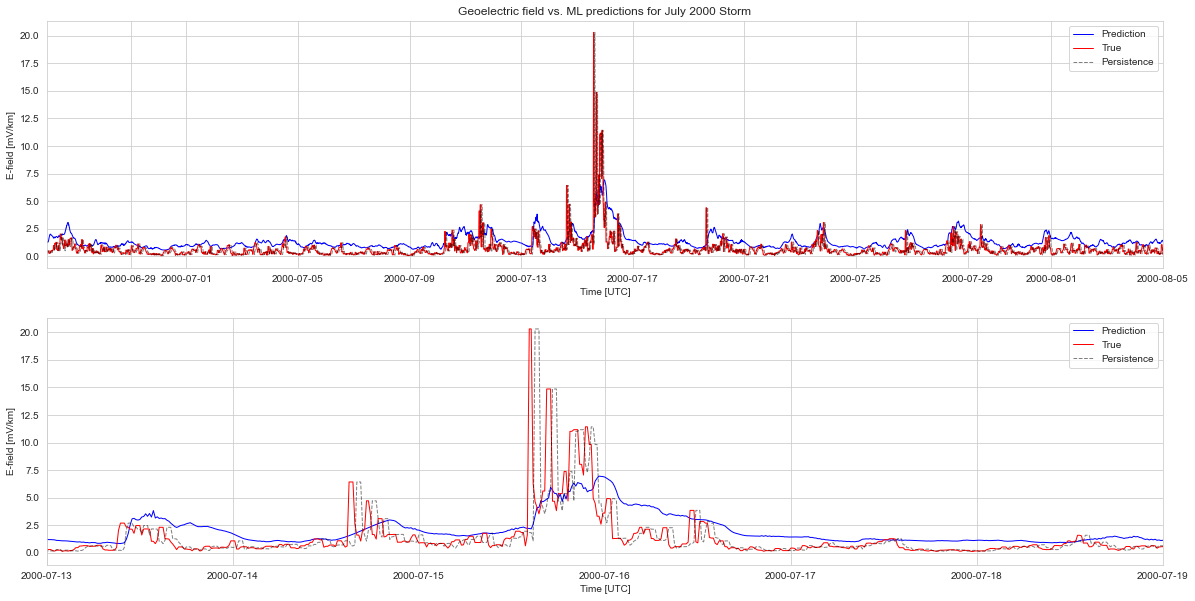

In [12]:
# CURRENT BEST MODEL
v = GIC1
iter_options = all_options[28]
n_seed = 123 

opt_batch_size, opt_patience, opt_loss_weights = iter_options[0], iter_options[1], iter_options[2]
opt_epochs, opt_rb_weights, opt_dropout = iter_options[3], iter_options[4], iter_options[5]
opt_nhidden = iter_options[6]
pdict = {'p': opt_patience, 'ep': opt_epochs, 'bs': opt_batch_size, 'do': opt_dropout,
         'lw': opt_loss_weights, 'rbw': opt_rb_weights, 'nh': opt_nhidden}

model_GIC1 = sw2gic.fit_model(v, pdict, fit_verbose=0, use_callback=False, plot_loss=False, seed=n_seed)
v.make_predictions(model_GIC1, threshold=gic_threshold, verbose=True)

In [35]:
# Save final model to file
model_GIC1.save(filename_GIC1_save_temp)
# Save parameters to file:
pdict_GIC1_save_temp = filename_GIC1_save_temp.replace('lstm', 'pdict').replace('.h5', '.p')
with open(pdict_GIC1_save_temp, 'wb') as handle:
    pickle.dump(pdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Model last saved on {}.".format(datetime.utcnow()))

Model last saved on 2021-09-02 07:40:20.655147.


#### Compare to best ever model

{'p': 8, 'ep': 15, 'bs': 64, 'do': 0.1, 'lw': [1000, 1], 'rbw': False, 'nh': 64}
POD = 0.31 (0.16)
POFD = 0.01 (0.01)
POD = 0.38 (0.26)
POFD = 0.03 (0.02)
POD = 0.43 (0.39)
POFD = 0.00 (0.00)

TRAIN / TEST DATASETS
----------------------
(train)	RMSE = 1.30 (1.92) mV/km 	PCC = 0.71 (0.52) 	ACC = 0.00 (0.00) 
(test)	RMSE = 1.85 (2.36) mV/km 	PCC = 0.64 (0.53) 	ACC = 0.00 (0.00) 


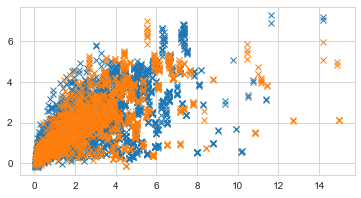


REAL-TIME APPLICATION
----------------------
(rt)	RMSE = 0.59 (0.51) mV/km 	PCC = 0.60 (0.61) 	ACC = 0.00 (0.00) 	TSS = 0.43 (0.39) 	BS = 0.98 (0.98) 


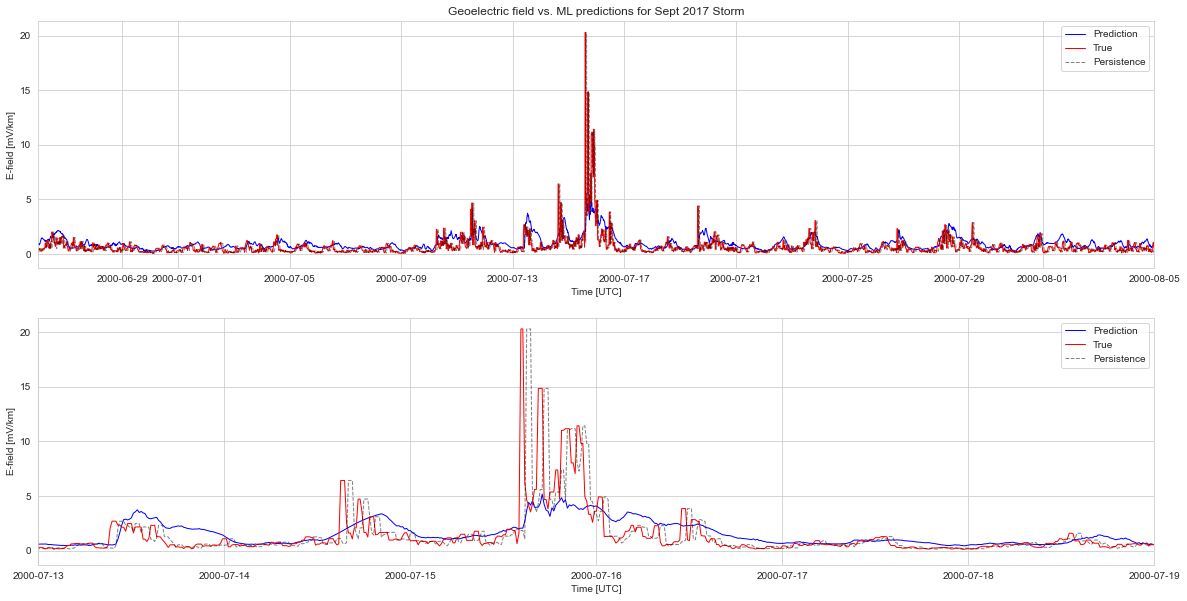

In [37]:
# Load best (ever) model
v = GIC1
custom_objects = {'BasicAttention': sw2gic.BasicAttention, 'min_max_loss': sw2gic.min_max_loss}
model_GIC1 = keras.models.load_model(filename_GIC1_save, custom_objects=custom_objects)
model_GIC1.compile(optimizer="adam",loss=[sw2gic.min_max_loss, keras.losses.BinaryCrossentropy()],loss_weights=[1000,1])
with open(filename_GIC1_save.replace('lstm', 'pdict').replace('.h5', '.p'), 'rb') as handle:
    pdict = pickle.load(handle)
print(pdict)

v.make_predictions(model_GIC1, threshold=4, verbose=True)

In [13]:
# Save final model to file
model_GIC1.save(filename_GIC1_save)
# Save parameters to file:
pdict_GIC1_save = filename_GIC1_save.replace('lstm', 'pdict').replace('.h5', '.p')
with open(pdict_GIC1_save, 'wb') as handle:
    pickle.dump(pdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Model last saved on {}.".format(datetime.utcnow()))

Model last saved on 2021-09-02 09:08:09.295404.


## Train on SS5

In [21]:
v = GIC5
print("Training on variable {} with parameters {}...\n".format(v.varname, v.suffix))
start_time_hpt = time.time()
cv_scores_hpt_GIC5 = run_hyperparameter_tuning(v, all_options, E_threshold=gic_threshold)
end_time_hpt = time.time()
print("")
print("Model runs took {} minutes!".format((end_time_hpt-start_time_hpt)/60.))

Training on variable GIC_fit_SS2 with parameters _0120_0040_0010...

Evaluating parameter set #1 of 30...
 -- Using seed 1!
    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=64
	restore_best_weights=False
	seed=1
	epochs=25
	use_callback=False
	p_dropout=0.1
	n_hidden=32
 -- Using seed 42!
 -- Using seed 123!
{'train': [1.3401388794891287, 1.3505791721746498, 1.353227111358633], 'test': [2.0649325378166807, 2.0707212779437767, 2.0962397903292693], 'rt': [0.9700331723573409, 0.8180111269103497, 0.9426366860192339]}
Evaluating parameter set #2 of 30...
 -- Using seed 1!
    Training with following parameters:
	patience=8
	loss_weights=[2000, 1]
	batch_size=32
	restore_best_weights=False
	seed=1
	epochs=10
	use_callback=False
	p_dropout=0.1
	n_hidden=128
 -- Using seed 42!
 -- Using seed 123!
{'train': [1.3982066494480456, 1.3450300452774002, 1.3315245984956339], 'test': [2.0937152307355005, 2.0434190407650457, 2.033374975676787], 'rt': [0.74122436878

In [22]:
print_hpt_results(all_options, cv_scores_hpt_GIC5, 'rmse')
print_hpt_results(all_options, cv_scores_hpt_GIC5, 'pcc')
print_hpt_results(all_options, cv_scores_hpt_GIC5, 'acc')
print_hpt_results(all_options, cv_scores_hpt_GIC5, 'TSS')
print_hpt_results(all_options, cv_scores_hpt_GIC5, 'HSS')

Printing results for rmse...
0) 1.348 - 2.077 - 0.910 - (64, 8, [2000, 1], 25, False, 0.1, 32)
1) 1.358 - 2.057 - 0.844 - (32, 8, [2000, 1], 10, False, 0.1, 128)
2) 1.202 - 2.113 - 0.957 - (16, 8, [1000, 1], 15, False, 0.1, 64)
3) 1.371 - 2.062 - 0.856 - (32, 8, [1000, 1], 10, False, 0.3, 128)
4) 1.224 - 2.097 - 0.948 - (32, 8, [1000, 1], 20, False, 0.3, 128)
5) 1.182 - 2.080 - 0.889 - (16, 8, [1000, 1], 20, False, 0.1, 32)
6) 1.470 - 2.058 - 0.848 - (64, 8, [1000, 1], 10, False, 0.3, 128)
7) 1.448 - 2.047 - 0.863 - (64, 8, [1000, 1], 10, False, 0.1, 32)
8) 1.239 - 2.078 - 0.998 - (16, 8, [2000, 1], 15, False, 0.3, 64)
9) 1.029 - 2.168 - 0.966 - (16, 8, [1000, 1], 25, False, 0.1, 128)
10) 1.351 - 2.083 - 0.916 - (64, 8, [1000, 1], 25, False, 0.3, 64)
11) 1.284 - 2.061 - 1.000 - (16, 8, [1000, 1], 10, False, 0.1, 64)
12) 1.185 - 2.111 - 0.968 - (32, 8, [1000, 1], 20, False, 0.1, 128)
13) 1.246 - 2.098 - 0.895 - (16, 8, [1000, 1], 15, False, 0.1, 32)
14) 1.118 - 2.092 - 0.994 - (16, 8, [

    Training with following parameters:
	patience=8
	loss_weights=[1000, 1]
	batch_size=64
	restore_best_weights=False
	seed=123
	epochs=20
	use_callback=False
	p_dropout=0.3
	n_hidden=64

TRAIN / TEST DATASETS
----------------------
(train)	RMSE = 1.39 (2.06) mV/km 	PCC = 0.67 (0.52) 	ACC = 0.00 (0.00) 
(test)	RMSE = 2.06 (2.43) mV/km 	PCC = 0.54 (0.55) 	ACC = 0.00 (0.00) 


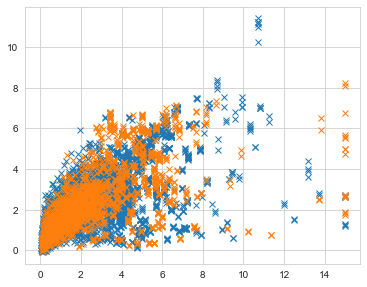


REAL-TIME APPLICATION
----------------------
(rt)	RMSE = 0.85 (0.60) mV/km 	PCC = 0.57 (0.60) 	ACC = 0.00 (0.00) 	TSS = 0.36 (0.33) 	BS = 1.02 (0.98) 


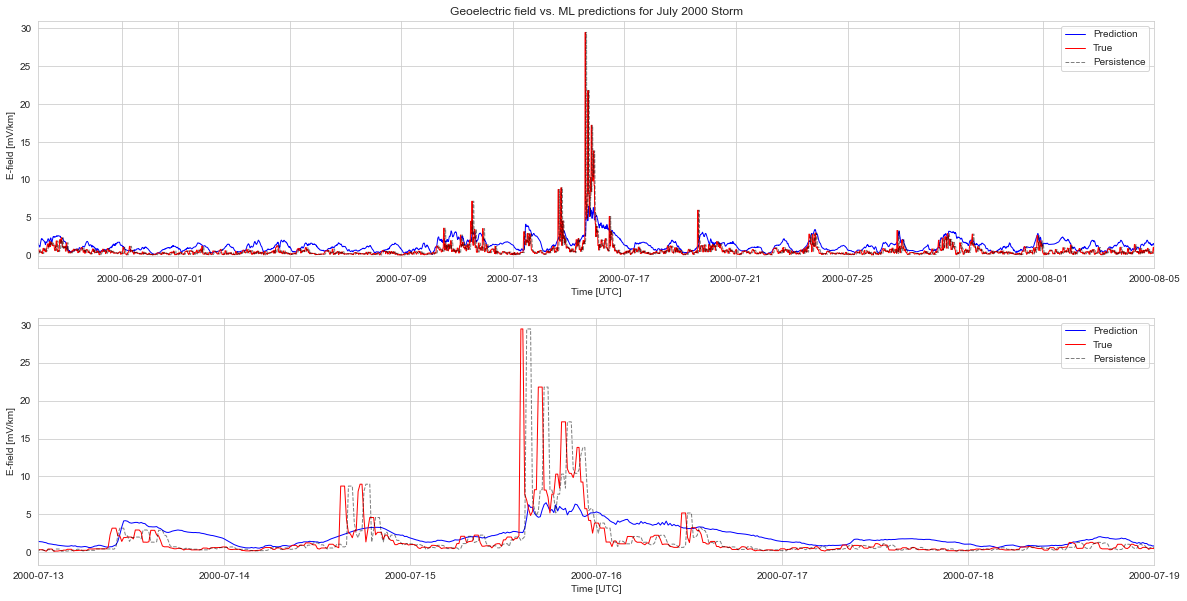

In [14]:
# CURRENT BEST MODEL
v = GIC5
iter_options = all_options[22]
n_seed = 123 # 1

opt_batch_size, opt_patience, opt_loss_weights = iter_options[0], iter_options[1], iter_options[2]
opt_epochs, opt_rb_weights, opt_dropout = iter_options[3], iter_options[4], iter_options[5]
opt_nhidden = iter_options[6]
pdict = {'p': opt_patience, 'ep': opt_epochs, 'bs': opt_batch_size, 'do': opt_dropout,
         'lw': opt_loss_weights, 'rbw': opt_rb_weights, 'nh': opt_nhidden}

model_GIC5 = sw2gic.fit_model(v, pdict, fit_verbose=0, use_callback=False, plot_loss=False, seed=n_seed)
v.make_predictions(model_GIC5, threshold=gic_threshold, verbose=True)

In [50]:
# Save final model to file
model_GIC5.save(filename_GIC5_save_temp)
# Save parameters to file:
pdict_GIC5_save_temp = filename_GIC5_save_temp.replace('lstm', 'pdict').replace('.h5', '.p')
with open(pdict_GIC5_save_temp, 'wb') as handle:
    pickle.dump(pdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Model last saved on {}.".format(datetime.utcnow()))

Model last saved on 2021-09-02 08:18:57.407458.


#### Compare to best ever model

{'p': 8, 'ep': 20, 'bs': 32, 'do': 0.3, 'lw': [1000, 1], 'rbw': False, 'nh': 128}
POD = 0.33 (0.15)
POFD = 0.00 (0.01)
POD = 0.31 (0.19)
POFD = 0.04 (0.02)
POD = 0.33 (0.33)
POFD = 0.00 (0.00)

TRAIN / TEST DATASETS
----------------------
(train)	RMSE = 1.47 (2.06) mV/km 	PCC = 0.67 (0.52) 	ACC = 0.00 (0.00) 
(test)	RMSE = 2.12 (2.43) mV/km 	PCC = 0.55 (0.55) 	ACC = 0.00 (0.00) 


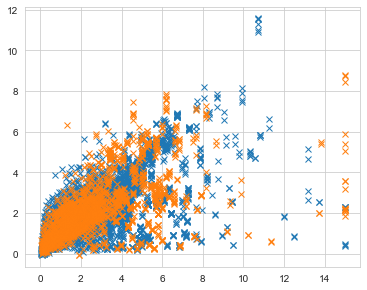


REAL-TIME APPLICATION
----------------------
(rt)	RMSE = 0.70 (0.60) mV/km 	PCC = 0.58 (0.60) 	ACC = 0.00 (0.00) 	TSS = 0.33 (0.33) 	BS = 0.67 (0.98) 


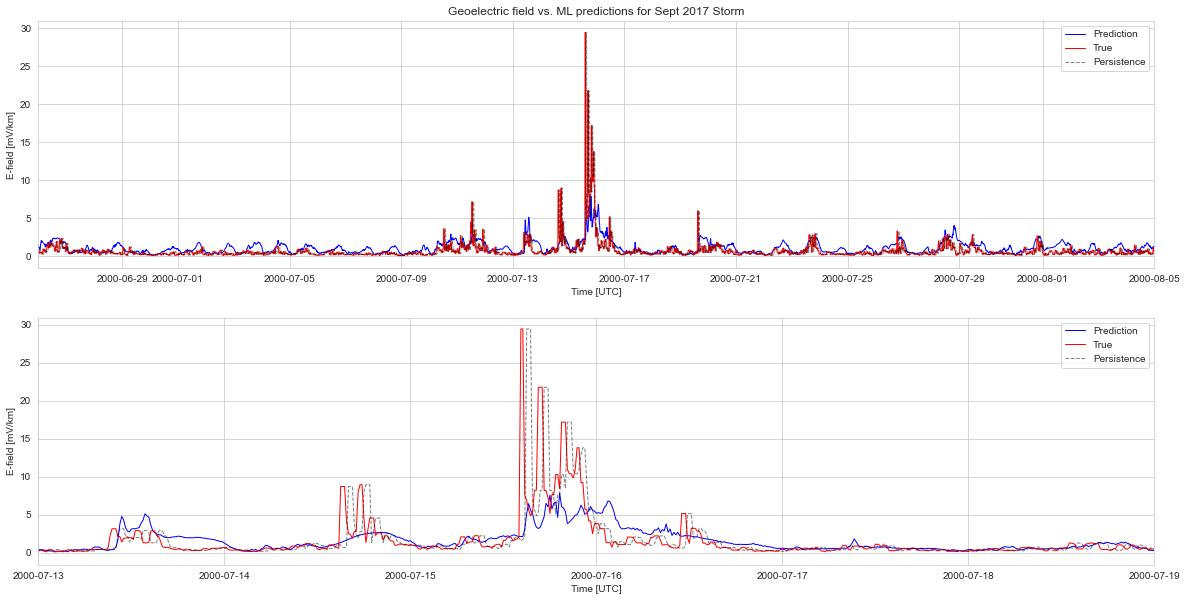

In [44]:
# Load best (ever) model
v = GIC5
custom_objects = {'BasicAttention': sw2gic.BasicAttention, 'min_max_loss': sw2gic.min_max_loss}
model_GIC5 = keras.models.load_model(filename_GIC5_save, custom_objects=custom_objects)
model_GIC5.compile(optimizer="adam",loss=[sw2gic.min_max_loss, keras.losses.BinaryCrossentropy()],loss_weights=[1000,1])
with open(filename_GIC5_save.replace('lstm', 'pdict').replace('.h5', '.p'), 'rb') as handle:
    pdict = pickle.load(handle)
print(pdict)

v.make_predictions(model_GIC5, threshold=gic_threshold, verbose=True)

In [15]:
# Save final model to file
model_GIC5.save(filename_GIC5_save)
# Save parameters to file:
pdict_GIC5_save = filename_GIC5_save.replace('lstm', 'pdict').replace('.h5', '.p')
with open(pdict_GIC5_save, 'wb') as handle:
    pickle.dump(pdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Model last saved on {}.".format(datetime.utcnow()))

Model last saved on 2021-09-02 09:10:31.483065.
